In [108]:
from sympy import gruntz


base_path = "D:/code/datasets/recognizing_emotions_from_faces"
oryginal_data_path = f"{base_path}/oryginal_data"
duplicates_data_path = f"{base_path}/duplicates"
data_without_duplicates_path = f"{base_path}/data_without_duplicates"
data_path = f"{base_path}/data"

In [2]:
import kagglehub
import os
import shutil

path = kagglehub.dataset_download("msambare/fer2013")
os.makedirs(base_path, exist_ok=True)
destination_path = os.path.join(base_path, os.path.basename(path))
shutil.move(path, destination_path)
print("Pliki zostały zapisane w:", destination_path)

100%|██████████| 60.3M/60.3M [00:04<00:00, 15.8MB/s]

Extracting files...


Pliki zostały zapisane w: D:/code/datasets/recognizing_emotions_from_faces\1


Połączyłem foldery TEST oraz TRAIN

In [26]:
classes_path = os.walk(base_path)
print("Ilość \t|\t\t\tŚcieżka")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {root}')
        if root.endswith("surprise"):
            print(80*"-")

Ilość 	|			Ścieżka
958 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\angry
111 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\disgust
1024 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\fear
1774 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\happy
1233 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\neutral
1247 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\sad
831 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\surprise
--------------------------------------------------------------------------------
3995 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\angry
436 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\disgust
4097 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\fear
7215 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\happy
4965 	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\neutral
4830 	|	 D:/code/datasets/recognizing_em

In [32]:
classes_path = os.walk(base_path)
for root, dirs, files in classes_path:
    if len(files) > 0:
        class_name = os.path.basename(root)
        print(f'{class_name}\t|\t {root}')
        shutil.copytree(os.path.join(root), os.path.join(oryginal_data_path, class_name, ), dirs_exist_ok=True)

angry	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\angry
disgust	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\disgust
fear	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\fear
happy	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\happy
neutral	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\neutral
sad	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\sad
surprise	|	 D:/code/datasets/recognizing_emotions_from_faces\1\test\surprise
angry	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\angry
disgust	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\disgust
fear	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\fear
happy	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\happy
neutral	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\neutral
sad	|	 D:/code/datasets/recognizing_emotions_from_faces\1\train\sad
surprise	|	 D:/code/datasets/recognizing_emotions_from_faces\

In [37]:
classes_path = os.walk(oryginal_data_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
4953 	|	 angry
547 	|	 disgust
5121 	|	 fear
8989 	|	 happy
6198 	|	 neutral
6077 	|	 sad
4002 	|	 surprise


|"(Docelowo wykluczę klasę "disgust"  z powodu małej ilości grafik.

#### Import wszystkich bibliotek

In [38]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import image_dataset_from_directory

#### Spojrzenie na dataset

In [43]:
full_dataset = image_dataset_from_directory(
                                      oryginal_data_path,
                                      image_size=(48, 48),
                                      label_mode='categorical',
                                      color_mode="grayscale",
                                      )

Found 35887 files belonging to 7 classes.


In [46]:
def plot_random_images(dataset, class_names, rows=4, cols=4):

    %matplotlib inline
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()

    for images, labels in dataset.take(1):
        for i in range(rows * cols):
            if i < len(images):
                ax = axes[i]
                ax.imshow(images[i].numpy().astype("uint8").squeeze(), cmap="gray")
                label_index = tf.argmax(labels[i]).numpy()
                ax.set_title(class_names[label_index])
                ax.axis("off")
            else:
                axes[i].axis("off")
    plt.tight_layout()
    plt.show()


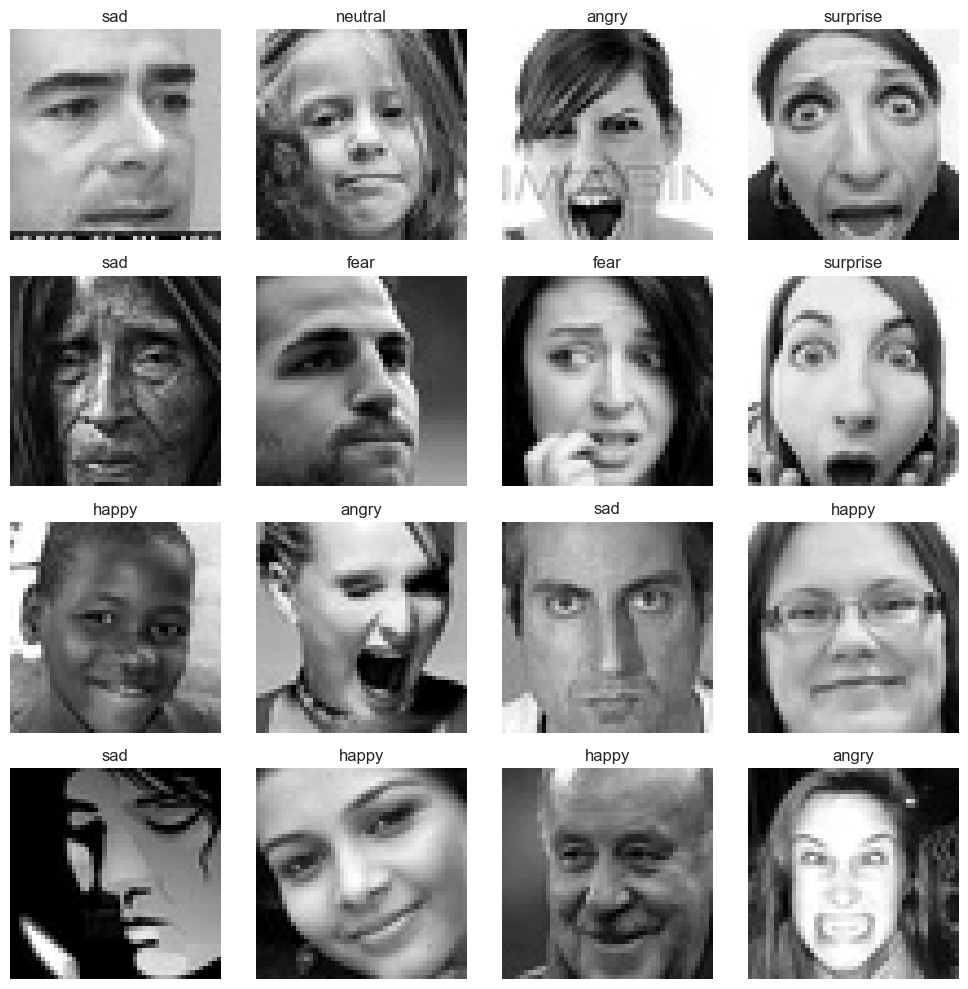

In [48]:
class_names = full_dataset.class_names
plot_random_images(full_dataset, class_names)

Można zauważyć, że przypisana klasa nie zawsze jest intuicyjna z naszego punktu widzenia, z tego powodu zmniejszę ilość grafik selekcjonując te, które najbardziej odzwierciedlają swoją klasę. Zrobię to z pomocą rozwiniętego projektu z poprzedniego semestru z Analizy Danych Multimedialnych "TAGGY".  Korzysta on z modelu "CLIP" dostarczanego przez OpenAI, którego używam z powodu możliwości zadeklarowania własnych klas. Wkleję tutaj jedynie metody wymagane do realizacji planowanego działania.

### Taggy - Detekcja duplikatów

#### HELP:
<code>python .\taggy_cli.py dataset_duplicates --help</code>


Usage: taggy_cli.py dataset_duplicates [OPTIONS]

  Finds and groups duplicate images based on their embedding similarity. Then
  organizes them into subfolders, picking 'best images' if desired.


Options:

-i, --input-dataset-path PATH   Path to the folder containing images.
                                  [required]

-o, --output-folder PATH        Folder to place grouped duplicates.

-l, --labels TEXT               List of labels used for grouping names of
                                  duplicates (if not provided, uses
                                  directories (classes) names ).

-op, --operation [copy|symlink|move]
                                  File operation(s) to perform when grouping
                                  duplicates.

-t, --similarity-threshold FLOAT
                                  Threshold (0..1) for considering images
                                  duplicates.

-b, --propose-best              If provided, proposes 'best' images to keep
                                  in each group.

--help                          Show this message and exit.

#### Użyta komenda:
<code>python .\taggy_cli.py dataset_duplicates -i D:\code\datasets\recognizing_emotions_from_faces\oryginal_data\ -o D:\code\datasets\recognizing_emotions_from_faces\duplicates\ -op copy -t 0.98 -b</code>

#### Wyniki w prezentacji. Wywołanie Taggy trwało ok. godziny (ASUS GTX 1060 3GB)

#### Prezentacja znalezionych duplikatów

In [86]:
import os
from PIL import Image
import time

def create_mosaic(folder, output="mosaic.jpg", thumb_size=(48, 48), per_row=10):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".jpg")]
    imgs = []
    for f in files:
        try:
            img = Image.open(os.path.join(folder, f)).convert("RGB")
            imgs.append(img.resize(thumb_size, resample=Image.Resampling.LANCZOS))
        except Exception:
            pass
    if not imgs:
        return None
    rows = (len(imgs) + per_row - 1) // per_row
    mosaic = Image.new("RGB", (thumb_size[0] * per_row, thumb_size[1] * rows))
    for i, img in enumerate(imgs):
        x = (i % per_row) * thumb_size[0]
        y = (i // per_row) * thumb_size[1]
        mosaic.paste(img, (x, y))
    mosaic.show(os.path.basename(output))
    mosaic.save(output)
    time.sleep(3)
    print("Saved mosaic to", output)
    return mosaic

In [87]:
groups_with_the_most_duplicates = {
    "angry": "angry_20",
    "disgust": "angry_61",
    "fear": "angry_60",
    "happy": "happy_11",
    "neutral": "angry_50",
    "sad": "angry_36",
    "surprise": "angry_84"
    }

In [88]:
for key, value in groups_with_the_most_duplicates.items():
    folder = os.path.join(duplicates_data_path, key, value)
    output = os.path.join(duplicates_data_path, key, f"{key}_example_duplicates.jpg")
    create_mosaic(folder=folder, output=output, thumb_size=(48, 48), per_row=10)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\angry\angry_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\disgust\disgust_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\fear\fear_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\neutral\neutral_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\sad\sad_example_duplicates.jpg
Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\surprise\surprise_example_duplicates.jpg


Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg


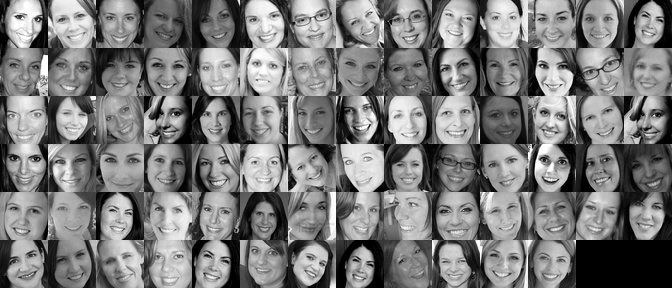

In [94]:
create_mosaic(os.path.join(duplicates_data_path, "happy", groups_with_the_most_duplicates.get("happy")), os.path.join(duplicates_data_path, "happy", "happy_example_duplicates.jpg"), thumb_size=(48, 48), per_row=14)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\happy\happy_example_duplicates.jpg


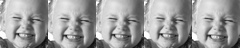

In [98]:
create_mosaic(os.path.join(duplicates_data_path, "happy", "happy_146"), os.path.join(duplicates_data_path, "happy", "happy_example_duplicates.jpg"), thumb_size=(48, 48), per_row=5)

Saved mosaic to D:/code/datasets/recognizing_emotions_from_faces/duplicates\surprise\surprise_example_duplicates.jpg


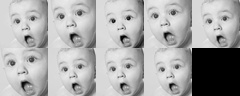

In [100]:
create_mosaic(os.path.join(duplicates_data_path, "surprise", "happy_288"), os.path.join(duplicates_data_path, "surprise", "surprise_example_duplicates.jpg"), thumb_size=(48, 48), per_row=5)

In [116]:
def load_skip_set(json_path):
    """
    Wczytuje plik JSON z folderu [nazwa_klasy] i buduje zbiór znormalizowanych ścieżek plików,
    które mają być pominięte przy kopiowaniu, używając os.path.join.
    """
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            groups = json.load(f)
    except FileNotFoundError:
        print(f"Błąd: Nie znaleziono pliku {json_path}")
        raise
    skip_set = set()
    for group in groups:
        for key in ["images", "best_images"]:
            for item in group.get(key, []):
                path = item.get("path")
                if path:
                    norm_path = os.path.normpath(path)
                    skip_set.add(norm_path)
    return skip_set

In [125]:
def copy_files(source_dir, dest_dir, skip_set):
    """
    Kopiuje wszystkie pliki z katalogu source_dir (rekurencyjnie) do dest_dir,
    pomijając te, których znormalizowane ścieżki znajdują się w skip_set.
    Używa os.path.join oraz os.walk.
    Pliki zapisywane są z rozszerzeniem .jpg. W przypadku konfliktu nazwy dodaje licznik.
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    skipped = 0
    copied = 0
    errors = []

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            abs_path = os.path.normpath(os.path.abspath(file_path))
            if abs_path in skip_set:
                skipped += 1
                continue

            base_name, _ = os.path.splitext(file)
            dest_file = os.path.join(dest_dir, base_name + ".jpg")
            counter = 1
            while os.path.exists(dest_file):
                dest_file = os.path.join(dest_dir, f"{base_name}_{counter}.jpg")
                counter += 1

            try:
                shutil.copy2(file_path, dest_file)
                copied += 1
            except Exception as e:
                errors.append(f"Błąd kopiowania {file_path}: {e}")

    print(f"[{os.path.basename(source_dir)}]Skopiowano {copied} plików, pominięto {skipped} plików.")

In [130]:
for class_name in groups_with_the_most_duplicates.keys():
    duplicates_class_path = os.path.join(duplicates_data_path, class_name)
    best_images_path = os.path.join(duplicates_class_path, "best_from_duplicates")
    json_path = os.path.join(duplicates_class_path, "grouped_images.json")
    src_path = os.path.join(oryginal_data_path, class_name)
    dest_path = os.path.join(data_without_duplicates_path, class_name)
    skip_set = load_skip_set(json_path)
    copy_files(src_path, dest_path, skip_set)
    print(f"Kopiuję {len(os.listdir(duplicates_class_path))} najlepszych grafik pośród duplikatów dla klasy {class_name}...")
    shutil.copytree(best_images_path, dest_path, dirs_exist_ok=True)
    print("Kopiowanie zakończone dla klasy:", class_name)

[angry]Skopiowano 3881 plików, pominięto 1072 plików.
Kopiuję 376 najlepszych grafik pośród duplikatów dla klasy angry...
Kopiowanie zakończone dla klasy: angry
[disgust]Skopiowano 274 plików, pominięto 273 plików.
Kopiuję 100 najlepszych grafik pośród duplikatów dla klasy disgust...
Kopiowanie zakończone dla klasy: disgust
[fear]Skopiowano 3556 plików, pominięto 1565 plików.
Kopiuję 587 najlepszych grafik pośród duplikatów dla klasy fear...
Kopiowanie zakończone dla klasy: fear
[happy]Skopiowano 8428 plików, pominięto 561 plików.
Kopiuję 267 najlepszych grafik pośród duplikatów dla klasy happy...
Kopiowanie zakończone dla klasy: happy
[neutral]Skopiowano 5488 plików, pominięto 710 plików.
Kopiuję 322 najlepszych grafik pośród duplikatów dla klasy neutral...
Kopiowanie zakończone dla klasy: neutral
[sad]Skopiowano 5018 plików, pominięto 1059 plików.
Kopiuję 420 najlepszych grafik pośród duplikatów dla klasy sad...
Kopiowanie zakończone dla klasy: sad
[surprise]Skopiowano 2309 plików, p

In [131]:
class_name = "happy_98"
duplicates_class_path = os.path.join(duplicates_data_path, class_name)
best_images_path = os.path.join(duplicates_class_path, "best_from_duplicates")
json_path = os.path.join(duplicates_class_path, "grouped_images.json")
src_path = os.path.join(oryginal_data_path, "happy")
dest_path = os.path.join(data_without_duplicates_path, class_name)
skip_set = load_skip_set(json_path)
copy_files(src_path, dest_path, skip_set)
print(f"Kopiuję {len(os.listdir(duplicates_class_path))} najlepszych grafik pośród duplikatów dla klasy {class_name}...")
shutil.copytree(best_images_path, dest_path, dirs_exist_ok=True)
print("Kopiowanie zakończone dla klasy:", class_name)

[happy]Skopiowano 7812 plików, pominięto 1177 plików.
Kopiuję 483 najlepszych grafik pośród duplikatów dla klasy happy_98...
Kopiowanie zakończone dla klasy: happy_98


In [132]:
classes_path = os.walk(data_without_duplicates_path)
print("Ilość \t|\tKlasa")
for root, dirs, files in classes_path:
    if len(files) > 0:
        print(f'{len(files)} \t|\t {os.path.basename(root)}')

Ilość 	|	Klasa
4252 	|	 angry
370 	|	 disgust
4139 	|	 fear
8692 	|	 happy
8289 	|	 happy_98
5806 	|	 neutral
5430 	|	 sad
2997 	|	 surprise


<code>python .\taggy_cli.py class_selection -i D:\code\datasets\recognizing_emotions_from_faces\data_without_duplicates\ -o D:\code\datasets\recognizing_emotions_from_faces\data\ --operation copy --additional-string face</code>


### Taggy - nie ma sensu oglądać, finalnie został użyty w wersji CLI

In [9]:
# logger
import logging
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

# Create a file handler to log messages to a file
file_handler = logging.FileHandler("../faces_recognition/logs_taggy.log")
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

logging.basicConfig(
    level=logging.DEBUG,
    handlers=[console_handler, file_handler],
)

logger = logging.getLogger("taggy")

In [10]:
logging.basicConfig(
    level=logging.DEBUG,
    handlers=[console_handler, file_handler],
)

##### Import bibliotek z projektu Taggy

In [11]:
import os
import click
import torch
import clip
import numpy as np
from PIL import Image

try:
    import cv2
except ImportError:
    cv2 = None
import shutil
from typing import List

import win32com.client
import json
import configparser

from click import pass_context

#### Metody wykonujące operacje na plikach

In [12]:
def create_directory(path):
    """
    Creates a directory if it does not exist.

    Args:
        path (str): Path to the directory.
    """
    if not os.path.exists(path):
        os.makedirs(path)
        logger.debug(f"Created directory: {path}")

def copy_file(src, dest):
    """
    Copies a file from src to dest, preserving metadata (timestamps, etc.).

    Args:
        src (str): Source file path.
        dest (str): Destination file path.
    """
    shutil.copy2(src, dest)

def perform_file_operation(src, dest_dir, operation, description=None, icon_path=None, filename=None):
    """
    Performs a file operation (copy or symlink/shortcut) from src to dest_dir.

    Args:
        src (str): Source file path.
        dest_dir (str): Destination directory path.
        operation (str): Type of operation ('copy', 'symlink', etc.).
        description (str, optional): Used if creating a shortcut. Defaults to None.
        icon_path (str, optional): Used if creating a shortcut. Defaults to None.
    """
    dest = os.path.join(dest_dir, os.path.basename(src))
    create_directory(dest_dir)

    if operation == "copy":
        copy_file(src, dest)
    if operation == "move" :
        shutil.move(src, dest)
    # if operation == "symlink":
    #     if os.name == "nt":
            # Windows shortcut
            # create_shortcut(src, dest + ".lnk", description, icon_path)
        # else:
            # Unix symlink
            # os.symlink(src, dest)
    if filename:
        os.rename(dest, os.path.join(dest_dir, filename))

def save_metadata_to_json(metadata, output_file):
    """
    Saves metadata to a JSON file.

    Args:
        metadata (dict or list): Metadata to be saved.
        output_file (str): Path to the output JSON file.
    """
    with open(output_file, 'w', encoding='utf-8') as json_file:
        json.dump(metadata, json_file, indent=4, ensure_ascii=False)
    logger.debug(f"Results saved to {output_file}")



def list_supported_image_files(images_path):
    """
    Returns a list of supported image file paths in the given directory.
    Supported extensions: png, jpg, jpeg, bmp, webp

    Args:
        images_path (str): Path to a folder containing images.

    Returns:
        List[str]: List of file paths found with supported extensions.
    """
    if not os.path.isdir(images_path):
        logger.warning(f"Directory does not exist: {images_path}")
        return []
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.webp')
    files = [
        os.path.join(images_path, f)
        for f in os.listdir(images_path)
        if f.lower().endswith(exts)
    ]
    return files


def preprocess_image(img_path, preprocess, device) -> torch.Tensor:
    """
    Opens and preprocesses a single image using the provided CLIP preprocess pipeline.

    Args:
        img_path (str): Path to the image file.
        preprocess (callable): The CLIP preprocess transform.
        device (str or torch.device): 'cpu' or 'cuda'.

    Returns:
        torch.Tensor: The preprocessed image on the appropriate device.z
    """
    pil_img = Image.open(img_path)
    img_tensor = preprocess(pil_img).unsqueeze(0).to(device)
    return img_tensor

#### Image tagger

In [13]:
class ImageTagger:
    """
    A class used to tag images, search for images by similarity, find and group duplicate images,
    and propose the best images in each group based on multiple metrics.

    Attributes:
        model_name (str): The name of the model to load.
        labels (list): List of possible tags.
        face_cascade_path (str): The path to the Haar cascade file for face detection.
        device (str): The device to run the model on (CPU or GPU).
        model (torch.nn.Module): The loaded CLIP model.
        preprocess (callable): The preprocessing function for the CLIP model.
    """

    def __init__(self,
                 model_name: str = "CLIP",
                 labels: list = None,
                 face_cascade_path: str = None):
        """
        Initializes the ImageTagger instance.

        Args:
            model_name (str): Name of the model to load. Defaults to "CLIP".
            labels (list, optional): List of possible tags. Defaults to None.
            face_cascade_path (str, optional): Path to the Haar cascade file for face detection. Defaults to None.
        """
        self.labels = labels
        self.model_name = model_name
        self.face_cascade_path = face_cascade_path

        if torch.cuda.is_available():
            logger.critical(f"CUDA available, device: {torch.cuda.get_device_name(0)}")
        else:
            logger.critical("CUDA not available, using CPU.")

        if model_name == "CLIP":
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            # self.device = "cpu"
            self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
            logger.info("CLIP model loaded successfully.")
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        if cv2 is None:
            logger.warning("OpenCV not installed. Face-detection-based metrics may be unavailable.")


    # ---------------------------------------
    # Search  image(s) similarity to query - command 'search'
    # ---------------------------------------
    def search_images(self, query: str, images_path: str, top_k: int = 5, output_path: str = None, operation: str = None):
        """
        Searches for images similar to a text query using the CLIP model.

        Args:
            query (str): The text query to search for.
            images_path (str): Path to the directory containing images.
            top_k (int, optional): Number of top similar images to return. Defaults to 5.
            output_path (str, optional): Path to save files what was found. Defaults to None.
            operation (str, optional): File operation. Defaults to "copy".

        Returns:
            list[tuple[str, float]]: A list of tuples containing image file paths and their similarity scores.
        """
        image_files, image_tensors = self._load_images(images_path)
        if len(image_files) == 0 or image_tensors.shape[0] == 0:
            logger.warning("No images to search in (sync).")
            return []
        logger.info(f"Searching for '{query}' in {len(image_files)} images ...")
        with torch.no_grad():
            image_features = self.model.encode_image(image_tensors).float()
        text_inputs = clip.tokenize([query]).to(self.device)
        with torch.no_grad():
            text_features = self.model.encode_text(text_inputs).float()

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarities = (text_features @ image_features.T).squeeze(0).cpu().numpy()
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        results = [(image_files[idx], float(similarities[idx])) for idx in sorted_indices]
        if output_path and results:
            for img_path, score in results:
                if top_k > 10:
                    filename = f"{score:.4f}_{os.path.basename(img_path)}"
                else:
                    filename = os.path.basename(img_path)
                perform_file_operation(img_path, output_path, operation, filename=filename)
            logger.info(f"Files saved to {output_path} with operation: {operation}")
        return results


    # ---------------------------------------
    # Find duplicates - command 'duplicates'
    # ---------------------------------------
    def find_duplicates(self, images_path: str, similarity_threshold: float = 0.9):
        """
        Identifies duplicate images by cosine similarity of embeddings, synchronously.

        This method loads images from the specified directory, computes their embeddings using the CLIP model,
        and then calculates the cosine similarity between each pair of images. If the similarity exceeds the
        specified threshold, the pair is considered a duplicate.

        Args:
            images_path (str): Path to the folder containing images.
            similarity_threshold (float): Threshold for considering images as duplicates, ranging from 0 to 1. Defaults to 0.9.

        Returns:
            list[tuple[str, str, float]]: A list of tuples where each tuple contains two image paths and their similarity score.
        """
        logger.info("Checking duplicates (sync) ...")
        image_files, image_tensors = self._load_images(images_path)
        if len(image_files) == 0 or image_tensors.shape[0] == 0:
            logger.warning("No images found for duplicate checking (sync).")
            return []

        logger.info(f"Loaded {len(image_files)} images for duplicate checking.")
        with torch.no_grad():
            image_features = self.model.encode_image(image_tensors).float()

        logger.info("Image features extracted.")
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity_matrix = image_features @ image_features.T
        logger.info("Similarity matrix computed.")

        duplicates = []
        num_images = len(image_files)
        total_pairs = (num_images * (num_images - 1)) // 2
        logger.info(f"Comparing {total_pairs} pairs of images ...")

        pair_gen = ((i, j) for i in range(num_images) for j in range(i + 1, num_images))
        logger.info("Starting comparison ...")

        with click.progressbar(pair_gen, label="Comparing pairs", length=total_pairs) as bar:
            for (i, j) in bar:
                similarity = float(similarity_matrix[i, j].item())
                if similarity >= similarity_threshold:
                    duplicates.append((image_files[i], image_files[j], similarity))

        return duplicates


    # ---------------------------------------
    # Group duplicates - command 'duplicates'
    # ---------------------------------------
    def group_duplicates(self,
                         duplicates: list,
                         output_folder: str,
                         operation: str = "copy",
                         propose_best: bool = True,
                         all_images: list = None,
                         best_scoring_method: str = "advanced"):
        """
        High-level method to group duplicates into subfolders, also handle non-duplicates.
        - Finds groups from duplicates
        - Processes each group (common tag, best images)
        - Places non-duplicate images in a 'non_duplicates' subfolder
        - Saves a JSON summary of everything

        Args:
            duplicates (list[tuple]): (img1, img2, similarity).
            output_folder (str): Where grouped images will be placed.
            operation (str, optional): File operation. Defaults to "copy".
            propose_best (bool, optional): Whether to measure quality. Defaults to True.
            all_images (list[str], optional): If provided, separate out non-duplicates. Defaults to None.
            best_scoring_method (str, optional): Method to score the best images. Defaults to "advanced".
        """
        grouped = _find_duplicate_groups(duplicates)
        group_records = self._process_duplicate_groups(
            grouped,
            output_folder,
            operation,
            propose_best,
            best_scoring_method=best_scoring_method
            )

        results_data = {
            "duplicates":     group_records,
            "non_duplicates": []
            }

        if all_images:
            duplicates_files = set()
            for images_ in grouped.values():
                duplicates_files.update(images_)
            non_duplicates_set = set(all_images) - duplicates_files

            if non_duplicates_set:
                non_dup_folder = os.path.join(output_folder, "non_duplicates")
                os.makedirs(non_dup_folder, exist_ok=True)

                for image_path in non_duplicates_set:
                    perform_file_operation(image_path, non_dup_folder, operation)
                    if propose_best:
                        gray = _load_image(image_path)
                        q = self._combined_image_score(gray)
                        results_data["non_duplicates"].append({
                            "path":  image_path,
                            "score": q
                            })
                    else:
                        results_data["non_duplicates"].append({"path": image_path})

                logger.info(f"Non-duplicates placed in {non_dup_folder}")
                if output_folder:
                    save_metadata_to_json(results_data, os.path.join(non_dup_folder, "non_duplicates.json"))


    # ---------------------------------------
    # Helper method used by commands "tag", "search" and "duplicates"
    # ---------------------------------------
    def _process_image(self, image_path: str, threshold: float, labels: list = None):
        """
        Forward pass (synchronous) through the CLIP model for a single image,
        returning labels above a probability threshold.

        Args:
            image_path (str): Path to the image file.
            labels (list): List of text labels.
            threshold (float): Probability threshold for tag assignment.

        Returns:
            list[dict]: A list of dictionaries with 'tag' and 'probability' keys.
        """
        if not labels:
            labels = self.labels
        try:
            image_tensor = preprocess_image(image_path, self.preprocess, self.device)
            text = clip.tokenize(labels).to(self.device)

            with torch.no_grad():
                logits_per_image, _ = self.model(image_tensor, text)
                probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

            if probs.ndim == 0:
                probs = [float(probs)]
            elif probs.ndim == 1:
                probs = probs.tolist()
            else:
                logger.error(f"Unexpected shape for probabilities: {probs.shape} in image {image_path}")
                return []

            results = [
                {"tag": label, "probability": float(prob)}
                for label, prob in zip(labels, probs)
                if prob >= threshold
                ]

            return results
        except Exception as e:
            logger.error(f"Error processing image {image_path} (sync): {str(e)}")
            return []



    # ---------------------------------------
    # Helper methods for commands "duplicates" and "search"
    # ---------------------------------------
    def _load_images(self, images_path: str):
        """
        Loads all images from a directory and preprocesses them into a Tensor (synchronously).

        Args:
            images_path (str): Path to the directory containing images.

        Returns:
            tuple(list[str], torch.Tensor):
                - List of image file paths
                - A concatenated torch.Tensor of preprocessed images
        """
        image_files = list_supported_image_files(images_path)
        if not image_files:
            return [], torch.empty(0)

        images = []
        with click.progressbar(image_files, label="Loading images") as bar:
            for img_path in bar:
                try:
                    img_tensor = preprocess_image(img_path, self.preprocess, self.device)
                    images.append(img_tensor)
                except Exception as e:
                    logger.error(f"Cannot open image {img_path}: {e}")

        if not images:
            return [], torch.empty(0)

        return image_files, torch.cat(images)



    # ---------------------------------------
    # Helper methods for command "duplicates"
    # ---------------------------------------
    def _process_duplicate_groups(self,
                                  grouped: dict,
                                  output_folder: str,
                                  operation: str = "copy",
                                  propose_best: bool = True,
                                  best_scoring_method: str = "advanced"):
        """
        Processes each group to:
        - Find the most common tag
        - Optionally measure quality to pick best images
        - Perform file operation and assemble result data

        Args:
            grouped (dict[int, set]): group_id => set of image paths
            output_folder (str): Destination folder
            operation (str, optional): File op ('copy', 'move', etc.). Defaults to "copy".
            propose_best (bool, optional): If True, measure image quality. Defaults to True.
            best_scoring_method (str, optional): "advanced" or "laplacian".

        Returns:
            list[dict]: A list of group records with info about images & best images
        """
        group_records = []
        for group_id, images_ in grouped.items():
            # gather tags
            tag_samples = []
            for image_path in images_:
                tags = self._generate_tags(image_path)
                tag_samples.extend(tags)
            most_common_tag = "group"
            if tag_samples:
                most_common_tag = max(set(tag_samples), key=tag_samples.count)

            # measure quality
            scored_images = []
            if propose_best:
                for image_path in images_:
                    gray_img = _load_image(image_path)
                    if gray_img is None:
                        score = 0.0
                    elif best_scoring_method == "advanced":
                        score = self._combined_image_score(gray_img)
                    else:
                        score = _calculate_sharpness(gray_img)
                    scored_images.append((image_path, score))
                scored_images.sort(key=lambda x: x[1], reverse=True)
                best_images = scored_images[:3]
            else:
                best_images = []

            # create group subfolder
            folder_name = f"{most_common_tag}_{group_id}"
            group_folder = os.path.join(output_folder, folder_name)
            os.makedirs(group_folder, exist_ok=True)

            # move/copy/symlink images
            group_images_info = []
            if propose_best:
                for (img_path, q) in scored_images:
                    perform_file_operation(img_path, group_folder, operation)
                    group_images_info.append({"path": img_path, "score": q})
            else:
                for img_path in images_:
                    perform_file_operation(img_path, group_folder, operation)
                    group_images_info.append({"path": img_path})
            if output_folder:
                logger.info(f"Group {group_id} ({len(images_)} images) => {group_folder}")
            record = {
                "group_id":    group_id,
                "tag":         most_common_tag,
                "folder_name": folder_name,
                "images":      group_images_info
                }
            if best_images:
                record["best_images"] = [
                    {"path": img_path, "score": score}
                    for (img_path, score) in best_images
                    ]
            group_records.append(record)

        logger.info(f"Operation on files: {operation}")
        if output_folder and group_records:
            save_metadata_to_json(group_records, os.path.join(output_folder, "grouped_images.json"))
        return group_records


    def _generate_tags(self, image_path: str, threshold: float = 0.3):
        """
        Generates a list of tag names for the given image.

        Args:
            image_path (str): Path to the image.
            threshold (float, optional): Probability threshold. Defaults to 0.3.

        Returns:
            list[str]: A list of tag names assigned to the image.
        """
        results = self._process_image(image_path, threshold)
        return [item["tag"] for item in results]


    def _combined_image_score(self, gray: np.ndarray):
        """
        Computes a combined image quality score based on sharpness and face detection.

        This method calculates the sharpness of the entire image using the variance of the Laplacian.
        If a Haar cascade file for face detection is available, it also calculates the sharpness of detected faces
        and combines these scores to produce a final quality score.

        Args:
            gray (np.ndarray): Grayscale image array.

        Returns:
            float: Combined image quality score.
        """
        base_sharpness = _calculate_sharpness(gray)

        if not os.path.exists(self.face_cascade_path):
            logger.warning(f"Haar cascade not found: {self.face_cascade_path}. Using sharpness only.")
            return base_sharpness * 0.3

        face_cascade = cv2.CascadeClassifier(self.face_cascade_path)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) == 0:
            return base_sharpness * 0.3

        face_sharpness = [_calculate_sharpness(gray[y:y + h, x:x + w]) for (x, y, w, h) in faces]
        avg_face_sharpness = sum(face_sharpness) / len(face_sharpness) if face_sharpness else 0.0

        return (avg_face_sharpness * 0.5) + (len(faces) * 0.2)



# ---------------------------------------
# Helper functions for command 'duplicates'
# ---------------------------------------
def _find_duplicate_groups(duplicates: list):
    """
    Builds a dictionary grouping sets of duplicates. Each group has a numeric ID.

    Args:
        duplicates (list[tuple]): e.g. list of (img1, img2, similarity).

    Returns:
        dict[int, set]: A mapping from group_id => set of image paths
    """
    grouped = {}
    with click.progressbar(duplicates, label="Grouping duplicates") as bar:
        for img1, img2, similarity in bar:
            group_id = None
            for existing_group_id, images_ in grouped.items():
                if img1 in images_ or img2 in images_:
                    group_id = existing_group_id
                    break
            if group_id is None:
                group_id = len(grouped) + 1
                grouped[group_id] = set()
            grouped[group_id].update([img1, img2])
    return grouped


def _measure_image_quality(image_path: str):
    """
    Naive 'sharpness' measure using the variance of the Laplacian
    on the entire image. Higher => sharper image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        float: Variance of Laplacian (0 if error or if cv2 missing).
    """
    if cv2 is None:
        return 0.0

    try:
        img_data = np.fromfile(image_path, dtype=np.uint8)
        img_cv2 = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
        if img_cv2 is None:
            return 0.0
        gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
        lap = cv2.Laplacian(gray, cv2.CV_64F)
        return float(lap.var())
    except Exception as e:
        logger.error(f"Error measuring quality for {image_path}: {e}")
        return 0.0


def _load_image(image_path: str):
    """
    Loads an image from the specified path and converts it to a grayscale image.

    This function uses OpenCV to read the image data from the file, decode it, and convert it to grayscale.
    If OpenCV is not available or the image cannot be loaded, it returns None.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: Grayscale image array if successful, None otherwise.
    """
    if cv2 is None:
        return None
    try:
        img_data = np.fromfile(image_path, dtype=np.uint8)
        img_cv2 = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
        if img_cv2 is None:
            raise ValueError("Invalid image data.")
        return cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        return None


def _calculate_sharpness(img_gray: np.ndarray):
    """
    Calculates the sharpness of a grayscale image using the variance of the Laplacian.

    This function computes the Laplacian of the image and returns the variance, which is a measure of sharpness.
    Higher variance indicates a sharper image.

    Args:
        img_gray (np.ndarray): Grayscale image array.

    Returns:
        float: Variance of the Laplacian, representing the image sharpness.
    """
    return float(cv2.Laplacian(img_gray, cv2.CV_64F).var())
# ---------------------------------------
# Aleksander Okrasa
# Please dont share this code with anyone
# ---------------------------------------

#### Taggy - CLI -

In [14]:
defaults = {"empty_defaults": "empty"}
@click.group()
@click.option('--config-file', '-c', default='taggy/config.ini', help='Path to the config file.')
@click.pass_context
def cli(ctx, config_file):
    """
    Main entry point for the Taggy CLI.
    """
    ctx.ensure_object(dict)
    # defaults = load_config(config_file)
    ctx.obj['defaults'] = defaults

    labels_from_config = defaults.get("labels", "random, general").split(',')
    labels = [label.strip() for label in labels_from_config]
    ctx.obj['labels'] = labels

    face_cascade_path = defaults.get("face_cascade_path", None)
    ctx.obj['face_cascade_path'] = face_cascade_path


@cli.command("duplicates")
@click.option("--images-path", "-i", type=click.Path(exists=True), required=True,
              help="Path to the folder containing images.")
@click.option("--output-folder", "-o", type=click.Path(),
              help="Folder to place grouped duplicates.")
@click.option("--labels", "-l",  multiple=True,
              help="List of labels used for grouping names of duplicates (if not provided, uses default).")
@click.option('--operation', '-op', type=click.Choice(['copy', 'symlink', 'move']),
              help='File operation(s) to perform when grouping duplicates.')
@click.option("--similarity-threshold", "-t", default=0.9, type=float,
              help="Threshold (0..1) for considering images duplicates.")
@click.option("--face-cascade", type=click.Path(exists=False), default=None,
              help="Path to the Haar cascade XML file for face detection.")
@click.option("--propose-best", "-b", is_flag=True,
              help="If provided, proposes 'best' images to keep in each group.")
@click.option("--best-method", type=click.Choice(["advanced", "laplacian"]), default="advanced",
              help="How to score 'best' images.")
@click.pass_context
def find_duplicates_cmd(ctx, images_path, output_folder, labels, operation, similarity_threshold, face_cascade, propose_best, best_method):
    """
    Finds and groups duplicate images based on their embedding similarity.
    Then organizes them into subfolders, picking 'best images' if desired.
    """
    # defaults = ctx.obj['defaults']
    if not operation:
        operation = defaults.get("operation", "symlink")
    if not labels:
        labels = ctx.obj.get('labels')
    if not face_cascade:
        face_cascade = ctx.obj['face_cascade_path']

    click.echo(f"Operation: {operation}, Labels: {labels}")
    click.echo(f"Finding duplicates in {images_path} with threshold={similarity_threshold} ...")

    tagger = ImageTagger(model_name="CLIP", face_cascade_path=face_cascade, labels=labels)

    duplicates = tagger.find_duplicates(images_path, similarity_threshold=similarity_threshold)
    if not duplicates:
        click.echo("No duplicates found.")
        return
    logger.info(f"Found {len(duplicates)} duplicate groups.")

    all_images = list_supported_image_files(images_path)
    output_folder=  output_folder if output_folder else f"{images_path}/taggy_output/duplicates/"
    tagger.group_duplicates(
        duplicates=duplicates,
        output_folder= output_folder,
        operation=operation,
        propose_best=propose_best,
        all_images=all_images if operation in ["copy", "symlink"] else None,
        best_scoring_method=best_method,
    )

    logger.info("Done grouping duplicates.")



@cli.command("search")
@click.option("--images-path", "-i", type=click.Path(exists=True), required=True,
              help="Path to the folder containing images.")
@click.option("--query", "-q", type=str, required=True,
              help="Text query for searching similar images.")
@click.option("--output-folder", "-o", type=click.Path(),
              help="Folder to place search results. Use if you want to do some operation on files what was found.")
@click.option("--operation", "-op", type=click.Choice(['copy', 'symlink', 'move']),
              default="copy", help="File operation to perform when searching images. Default is 'copy'")
@click.option("--top-k", "-k", type=int, default=5,
              help="Number of top results to return.")
def search_images_cmd(images_path, query, top_k, output_folder, operation):
    """
    Searches for images most similar to the provided text query using CLIP embeddings.
    """
    click.echo(f"Searching images in {images_path} for query='{query}'...")
    tagger = ImageTagger(model_name="CLIP")

    results = tagger.search_images(query, images_path, top_k=top_k, output_path=output_folder, operation=operation)
    if not results:
        click.echo("No results found (no images or none matched).")
        return

    click.echo(f"Top {top_k} results for '{query}':")
    for i, (img_path, score) in enumerate(results):
        click.echo(f"{i+1}. {img_path} => similarity={score:.4f}")


@cli.command("class_selection")
@click.option("--images-path", "-i", type=click.Path(exists=True), required=True,
              help="Path to the folder containing images.")
@click.option("--output-folder", "-o", type=click.Path(),
                help="Folder to place grouped images.")
@click.option("--labels", "-l",  multiple=True,
                help="List of (classes/labels) used for grouping names of duplicates (if not provided, uses default).")
@click.option("--operation", "-op", type=click.Choice(['copy', 'symlink', 'move']),
                help="File operation to perform when grouping images.")
@click.option("--threshold", "-t", default=0.8, type=float,
                help="Minimum probability threshold for assigning a label.")
@click.option("--top-k", "-k", type=int, default=100,)
@pass_context
def class_selection_cmd(ctx, images_path, output_folder, labels, operation, threshold, top_k):
    """
    Groups images based on their class (label) using the CLIP model.
    """
    click.echo(f"Classifying images in {images_path} ...")
    directories = os.listdir(images_path)
    print(directories)
    for directory in directories:
        input_directory = os.path.join(images_path, directory)

        click.echo(type(directory))
        click.echo(f"Directory: {directory}")
        click.echo(f"is dir? {os.path.isdir(directory)}")
        if os.path.isdir(input_directory):
            output_directory = os.path.join(output_folder, directory)
            click.echo(f"Classifying images in {input_directory} ...")
            ctx.invoke(search_images_cmd, images_path=input_directory, query=directory, top_k=top_k, output_folder=output_directory, operation=operation)
    logger.info("Done classifying images.")

Przejrzenie danych pod kątem duplikatów

In [50]:
# find_duplicates_cmd(["-i", f"{data_path}/happy", "--similarity-threshold", 0.999, "-o", f"{data_path}/taggy_output/duplicates-happy/", "--propose-best", "-op", "symlink", "-l", 'general', '--face-cascade', 'haarcascade_frontalface_default.xml'])

Operation: symlink, Labels: ('general',)
Finding duplicates in D:/code/animal-color-classification//1/1/train/happy with threshold=0.999 ...


2025-03-15 12:02:13,097 - CRITICAL - CUDA available, device: NVIDIA GeForce GTX 1060 3GB
2025-03-15 12:02:15,690 - INFO - CLIP model loaded successfully.
2025-03-15 12:02:15,690 - INFO - Checking duplicates (sync) ...


Loading images


2025-03-15 12:03:24,286 - INFO - Loaded 8989 images for duplicate checking.
2025-03-15 12:10:53,880 - INFO - Image features extracted.
2025-03-15 12:10:53,883 - INFO - Similarity matrix computed.
2025-03-15 12:10:53,883 - INFO - Comparing 40396566 pairs of images ...
2025-03-15 12:10:53,884 - INFO - Starting comparison ...


Comparing pairs


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [26]:
find_duplicates_cmd(["-i", f"{data_path}/angry", "--similarity-threshold", 0.99, "-o", f"{data_path}/taggy_output/duplicates-angry/", "--propose-best", "-op", "copy", "-l", 'happy', '-l', 'angry', '-l', 'sad', '-l', 'neutral', '-l', 'suprise', '-l', 'fear', '--best-method', 'laplacian', '--face-cascade', 'haarcascade_frontalface_default.xml'])

Operation: copy, Labels: ('happy', 'angry', 'sad', 'neutral', 'suprise', 'fear')
Finding duplicates in D:/code/animal-color-classification//1/1/train/angry with threshold=0.99 ...


2025-03-15 12:32:23,573 - CRITICAL - CUDA available, device: NVIDIA GeForce GTX 1060 3GB
2025-03-15 12:32:25,402 - INFO - CLIP model loaded successfully.
2025-03-15 12:32:25,402 - INFO - Checking duplicates (sync) ...


Loading images


2025-03-15 12:32:31,657 - INFO - Loaded 3995 images for duplicate checking.
2025-03-15 12:37:03,050 - INFO - Image features extracted.
2025-03-15 12:37:03,098 - INFO - Similarity matrix computed.
2025-03-15 12:37:03,099 - INFO - Comparing 7978015 pairs of images ...
2025-03-15 12:37:03,100 - INFO - Starting comparison ...


Comparing pairs


2025-03-15 12:41:18,443 - INFO - Found 622 duplicate groups.


Grouping duplicates


2025-03-15 12:41:19,155 - INFO - Group 1 (7 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/neutral_1
2025-03-15 12:41:19,315 - INFO - Group 2 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_2
2025-03-15 12:41:19,476 - INFO - Group 3 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_3
2025-03-15 12:41:19,714 - INFO - Group 4 (3 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_4
2025-03-15 12:41:19,871 - INFO - Group 5 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_5
2025-03-15 12:41:20,256 - INFO - Group 6 (5 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_6
2025-03-15 12:41:20,899 - INFO - Group 7 (8 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/angry_7
2025-03-15 12:41:2

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [15]:
import os
from PIL import Image

def create_mosaic(folder, output="mosaic.jpg", thumb_size=(48, 48), per_row=10):
    files = [f for f in os.listdir(folder) if f.lower().endswith(".jpg")]
    imgs = []
    for f in files:
        try:
            img = Image.open(os.path.join(folder, f)).convert("RGB")
            imgs.append(img.resize(thumb_size, resample=Image.Resampling.LANCZOS))
        except Exception:
            pass
    if not imgs:
        return None
    rows = (len(imgs) + per_row - 1) // per_row
    mosaic = Image.new("RGB", (thumb_size[0] * per_row, thumb_size[1] * rows))
    for i, img in enumerate(imgs):
        x = (i % per_row) * thumb_size[0]
        y = (i // per_row) * thumb_size[1]
        mosaic.paste(img, (x, y))
    # mosaic.show()
    mosaic.save(output)
    print("Saved mosaic to", output)
    return mosaic

In [16]:
import random


max_images = 0
while max_images < 5 :
    i = random.randint(1, len(os.listdir(data_path)))
    try:
        m = create_mosaic(f'{data_path}/taggy_output/duplicates-angry/angry_{i}/', f'{data_path}/taggy_output/duplicates-angry/similarity_mosaic_{i}.jpg')
        if m:
            max_images +=1
            # m.show()
    except Exception:
        pass
m.show()

Saved mosaic to D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/similarity_mosaic_8.jpg
Saved mosaic to D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/similarity_mosaic_8.jpg
Saved mosaic to D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/similarity_mosaic_2.jpg
Saved mosaic to D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/similarity_mosaic_7.jpg
Saved mosaic to D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-angry/similarity_mosaic_4.jpg


Widać, że część grafik się powtarza. Z tego powodu przefiltruję największy zbiór, czyli happy, który ma prawie 9000 oznaczonych danych, a angry posiada 4000.

 Aby klasy były równoważne, oraz większość grafik wnosiła coś nowego, a wagi były dobrze rozłożone przefiltruję klasę "happy".

In [17]:
find_duplicates_cmd(["-i", f"{data_path}/happy", "--similarity-threshold", 0.986, "-o", f"{data_path}/taggy_output/duplicates-happy/", "--propose-best", "-op", "copy", "-l", 'happy', '-l', 'angry', '-l', 'sad', '-l', 'neutral', '-l', 'suprise', '-l', 'fear', '--best-method', 'laplacian', '--face-cascade', 'haarcascade_frontalface_default.xml'])

Operation: copy, Labels: ('happy', 'angry', 'sad', 'neutral', 'suprise', 'fear')
Finding duplicates in D:/code/animal-color-classification//1/1/train/happy with threshold=0.986 ...


2025-03-15 13:46:12,880 - CRITICAL - CUDA available, device: NVIDIA GeForce GTX 1060 3GB
2025-03-15 13:46:15,026 - INFO - CLIP model loaded successfully.
2025-03-15 13:46:15,027 - INFO - Checking duplicates (sync) ...


Loading images


2025-03-15 13:47:37,032 - INFO - Loaded 8989 images for duplicate checking.
2025-03-15 13:54:55,763 - INFO - Image features extracted.
2025-03-15 13:54:55,814 - INFO - Similarity matrix computed.
2025-03-15 13:54:55,815 - INFO - Comparing 40396566 pairs of images ...
2025-03-15 13:54:55,815 - INFO - Starting comparison ...


Comparing pairs


2025-03-15 14:15:24,636 - INFO - Found 438 duplicate groups.


Grouping duplicates


2025-03-15 14:15:25,045 - INFO - Group 1 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/happy_1
2025-03-15 14:15:25,227 - INFO - Group 2 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/happy_2
2025-03-15 14:15:25,404 - INFO - Group 3 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/fear_3
2025-03-15 14:15:26,853 - INFO - Group 4 (3 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/happy_4
2025-03-15 14:15:27,038 - INFO - Group 5 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/angry_5
2025-03-15 14:15:27,302 - INFO - Group 6 (3 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/happy_6
2025-03-15 14:15:27,481 - INFO - Group 7 (2 images) => D:/code/animal-color-classification//1/1/train/taggy_output/duplicates-happy/happy_7
2025-03-15 14:15:27,6

AttributeError: 'tuple' object has no attribute 'tb_frame'

sad

In [ ]:
test